In [1]:
import torch
print(torch.__version__)

from loss_functions import *
from model_testing import *
from adversarial_attacks import *

from modules import *
from data_loader import *

import os

#GPU/CUDA setup
if torch.cuda.is_available():
    print("CUDA enabled!")
    device = torch.device('cuda:0')  # You can specify the index of the CUDA device you want to use
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Specify the index of the GPU(s) you want to use
else:
    print("CUDA not available. Using CPU.")
    device = torch.device('cpu')

data_folder = 'data'
batch_size = 250
n_workers = 0
random_seed = 0

# download MNIST data
test_loader = get_test_loader(data_folder, batch_size, shuffle=True, num_workers=n_workers, pin_memory=True)

# download MNIST data
train_loader, val_loader = get_train_val_loader(data_folder, batch_size, random_seed, augment=False, val_size=0.2,
                           shuffle=True, show_sample=False, num_workers=0, pin_memory=True)

2.6.0
CUDA not available. Using CPU.


In [2]:
def sinifgsm(model, images, labels, eps=8/255, alpha=2/255, steps=10, decay=1.0, m=5, targeted=False, device=None, random_start=False):
    """
    SI-NI-FGSM attack as described in 'NESTEROV ACCELERATED GRADIENT AND SCALE-INVARIANCE FOR ADVERSARIAL ATTACKS'.
    
    Args:
        model (torch.nn.Module): The target model.
        images (torch.Tensor): Input images of shape (N, C, H, W), values in range [0,1].
        labels (torch.Tensor): True labels for untargeted attack, target labels for targeted attack.
        eps (float): Maximum perturbation. Default: 8/255.
        alpha (float): Step size. Default: 2/255.
        steps (int): Number of iterations. Default: 10.
        decay (float): Momentum factor. Default: 1.0.
        m (int): Number of scale copies. Default: 5.
        targeted (bool): Whether to perform a targeted attack. Default: False.
        device (str or torch.device, optional): Device to run computations on.

    Returns:
        torch.Tensor: Adversarial examples of the same shape as `images`.
    """
    
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)
    
    momentum = torch.zeros_like(images).to(device)
    loss_fn = nn.CrossEntropyLoss()
    
    adv_images = images.clone().detach()

    for _ in range(steps):
        adv_images.requires_grad = True
        nes_image = adv_images + decay * alpha * momentum
        
        adv_grad = torch.zeros_like(images).to(device)

        for i in range(m):
            scaled_images = nes_image / (2 ** i)
            outputs = model(scaled_images)
            
            loss = -loss_fn(outputs, labels) if targeted else loss_fn(outputs, labels)
            
            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]
            adv_grad += grad
        
        adv_grad = adv_grad / m
        
        # Update adversarial images
        grad = decay * momentum + adv_grad / torch.mean(torch.abs(adv_grad), dim=(1,2,3), keepdim=True)
        momentum = grad
        adv_images = adv_images.detach() + alpha * grad.sign()
        delta = torch.clamp(adv_images - images, min=-eps, max=eps)
        adv_images = torch.clamp(images + delta, min=0, max=1).detach()

    return adv_images


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


paths = {"B30": "./saved_model/mnist_model/mnist_cae_balanced_clstsep_1500_0.002_250_True_0.0_20_1_1_1_1.0_0.0_30_4_32_1/mnist_cae00750.pth",
         "S30": "./saved_model/mnist_model/mnist_cae_standard_default_1500_0.002_250_False_0.5_20_1_1_1_0.8_0.2_30_4_32_1/mnist_cae00750.pth",
         "S15": "./saved_model/mnist_model/mnist_cae_standard_default_1500_0.002_250_False_0.5_20_1_1_1_0.8_0.2_15_4_32_1/mnist_cae00750.pth",
         "RS30": "./saved_model/mnist_model/mnist_cae_adversarial_standard_default_pdglinf_ce_20_0.3_0.02_True_1500_0.002_250_False_0.5_20_1_1_1_0.8_0.2_1.0_30_4_32_1/mnist_cae_adv00750.pth",
         "RB30": "./saved_model/mnist_model/mnist_cae_adversarial_balanced_clstsep_pdglinf_ce_20_0.3_0.02_True_800_0.002_250_True_0.0_20_1_1_1_1.0_0.0_1.0_30_4_32_1/mnist_cae_adv00750.pth",
         "FTB30n": "./saved_model/mnist_model/mnist_cae_FT_30_nothing_pdglinf_ce_20_0.3_0.02_True_20_0.002_250_20_1_1_1_1.0_0.0_1/mnist_cae_adv00020.pth",
         "FTB30a": "./saved_model/mnist_model/mnist_cae_FT_30_autoencoder_pdglinf_ce_20_0.3_0.02_True_20_0.002_250_20_1_1_1_1.0_0.0_1/mnist_cae_adv00020.pth",
         "FTB30p": "./saved_model/mnist_model/mnist_cae_FT_30_prototypes_pdglinf_ce_20_0.3_0.02_True_20_0.002_250_20_1_1_1_1.0_0.0_1/mnist_cae_adv00020.pth"}

s15 = torch.load(paths["S15"], weights_only=False)
s30 = torch.load(paths["S30"], weights_only=False)
b30 = torch.load(paths["B30"], weights_only=False)
rs30 = torch.load(paths["RS30"], map_location=torch.device('cpu'), weights_only=False)
rb30 = torch.load(paths["RB30"], map_location=torch.device('cpu'), weights_only=False)
ftb30n = torch.load(paths["FTB30n"], map_location=torch.device('cpu'), weights_only=False)
ftb30a = torch.load(paths["FTB30a"], map_location=torch.device('cpu'), weights_only=False)
ftb30p = torch.load(paths["FTB30p"], map_location=torch.device('cpu'), weights_only=False)

s15.to(device)
s30.to(device)
b30.to(device)
rs30.to(device)
rb30.to(device)
ftb30a.to(device)
ftb30n.to(device)
ftb30p.to(device)

print("MODELS LOADED")

MODELS LOADED


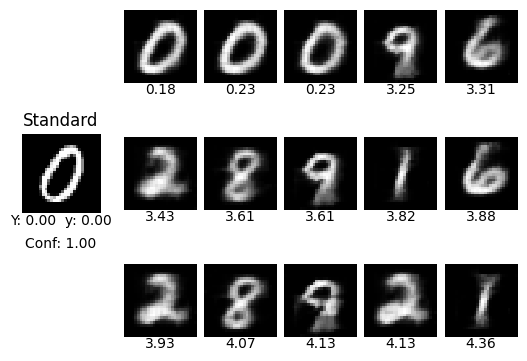

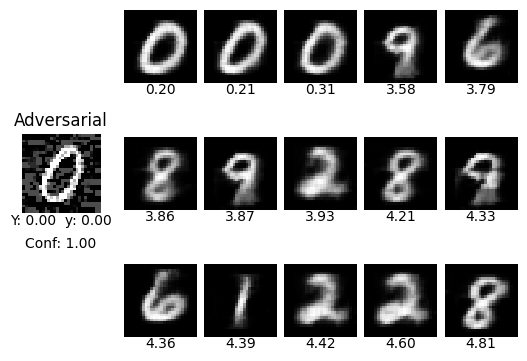

test set:
	accuracy: 0.9842
adversarial test set:
	accuracy: 0.9793
	Correctly classified and the closest prototype is different: 0.2687
	Correctly classified and the closest prototype is the same: 0.7106
	Incorrectly classified and the closest prototype is the same: 0.0077
	Incorrectly classified and the closest prototype is different: 0.0130


In [6]:
model1 = ftb30p

alpha = 0.01
iters = 40
eps = 0.3
random_start = True

examples_type = "cdp" # Incorrectly classified and the closest prototype is different.
n_examples = 1

attack = partial(PGDLInf_attack, alpha=alpha, iters=iters, eps=eps, random_start=random_start)
loss = partial(Loss_1, model = model1, alpha1=0, alpha2 = 1, objective = "cecc", force_class = None, change_expl = None)

test_adversarial(model1, test_loader, attack=attack, loss=loss, n_examples=n_examples, examples_type=examples_type)

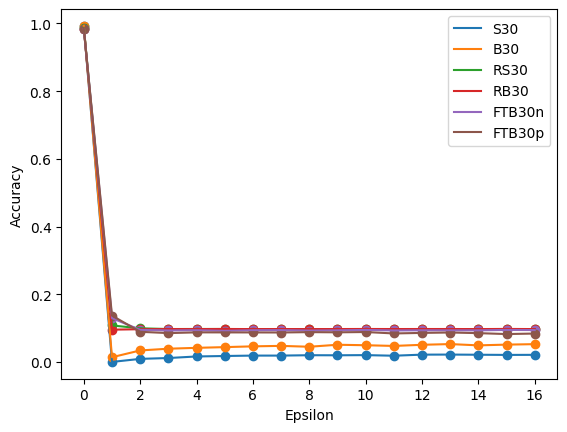

In [10]:
iters = 4
max_eps = 16
step = 0.5
random_start = True

models = [s30, b30, rs30, rb30, ftb30n, ftb30p]
model_names = ["S30", "B30", "RS30", "RB30", "FTB30n", "FTB30p"]
#attack = partial(PGDLInf_attack, iters=iters, random_start=True)
attack = partial(PGDLInf_attack, alpha=alpha, iters=iters, eps=eps, random_start=random_start)
loss = CELoss
#loss = partial(Loss_1, alpha1=0, alpha2 = 1, objective = "cecc", force_class = None, change_expl = None)

adversarial_attacks_eps_plot(models, model_names, test_loader, attack, loss, max_eps, step=step)

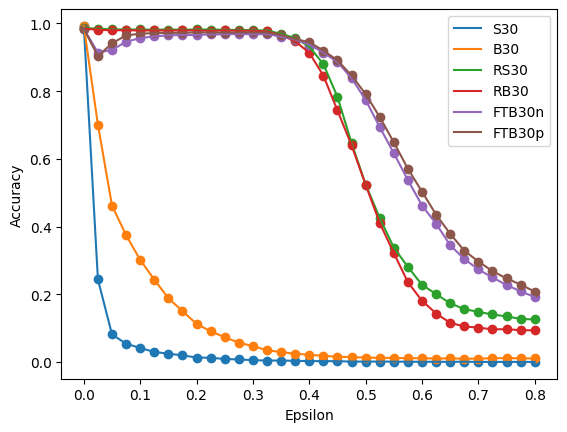

In [12]:
iters = 4
max_eps = 0.8
step = 0.025
random_start = True

models = [s30, b30, rs30, rb30, ftb30n, ftb30p]
model_names = ["S30", "B30", "RS30", "RB30", "FTB30n", "FTB30p"]
#attack = partial(PGDLInf_attack, iters=iters, random_start=random_start)
attack = partial(PGDLInf_attack, alpha=alpha, iters=iters, eps=eps, random_start=random_start)
loss = CELoss

adversarial_attacks_eps_plot(models, model_names, test_loader, attack, loss, max_eps, step=step)

# Más pruebas de ataques

## clase attack

In [35]:
import time
from collections import OrderedDict

import torch
from torch.utils.data import DataLoader, TensorDataset


def wrapper_method(func):
    def wrapper_func(self, *args, **kwargs):
        result = func(self, *args, **kwargs)
        for atk in self.__dict__.get("_attacks").values():
            eval("atk." + func.__name__ + "(*args, **kwargs)")
        return result

    return wrapper_func


class Attack(object):
    r"""
    Base class for all attacks.

    .. note::
        It automatically set device to the device where given model is.
        It basically changes training mode to eval during attack process.
        To change this, please see `set_model_training_mode`.
    """

    def __init__(self, name, model):
        r"""
        Initializes internal attack state.

        Arguments:
            name (str): name of attack.
            model (torch.nn.Module): model to attack.
        """

        self.attack = name
        self._attacks = OrderedDict()

        self.set_model(model)
        try:
            self.device = next(model.parameters()).device
        except Exception:
            self.device = None
            print("Failed to set device automatically, please try set_device() manual.")

        # Controls attack mode.
        self.attack_mode = "default"
        self.supported_mode = ["default"]
        self.targeted = False
        self._target_map_function = None

        # Controls when normalization is used.
        self.normalization_used = None
        self._normalization_applied = None
        if self.model.__class__.__name__ == "RobModel":
            self._set_rmodel_normalization_used(model)

        # Controls model mode during attack.
        self._model_training = False
        self._batchnorm_training = False
        self._dropout_training = False

    def forward(self, inputs, labels=None, *args, **kwargs):
        r"""
        It defines the computation performed at every call.
        Should be overridden by all subclasses.
        """
        raise NotImplementedError

    @wrapper_method
    def set_model(self, model):
        self.model = model
        self.model_name = model.__class__.__name__

    def get_logits(self, inputs, labels=None, *args, **kwargs):
        if self._normalization_applied is False:
            inputs = self.normalize(inputs)
        logits = self.model(inputs)
        return logits

    @wrapper_method
    def _set_normalization_applied(self, flag):
        self._normalization_applied = flag

    @wrapper_method
    def set_device(self, device):
        self.device = device

    @wrapper_method
    def _set_rmodel_normalization_used(self, model):
        r"""
        Set attack normalization for MAIR [https://github.com/Harry24k/MAIR].

        """
        mean = getattr(model, "mean", None)
        std = getattr(model, "std", None)
        if (mean is not None) and (std is not None):
            if isinstance(mean, torch.Tensor):
                mean = mean.cpu().numpy()
            if isinstance(std, torch.Tensor):
                std = std.cpu().numpy()
            if (mean != 0).all() or (std != 1).all():
                self.set_normalization_used(mean, std)

    @wrapper_method
    def set_normalization_used(self, mean, std):
        self.normalization_used = {}
        n_channels = len(mean)
        mean = torch.tensor(mean).reshape(1, n_channels, 1, 1)
        std = torch.tensor(std).reshape(1, n_channels, 1, 1)
        self.normalization_used["mean"] = mean
        self.normalization_used["std"] = std
        self._set_normalization_applied(True)

    def normalize(self, inputs):
        mean = self.normalization_used["mean"].to(inputs.device)
        std = self.normalization_used["std"].to(inputs.device)
        return (inputs - mean) / std

    def inverse_normalize(self, inputs):
        mean = self.normalization_used["mean"].to(inputs.device)
        std = self.normalization_used["std"].to(inputs.device)
        return inputs * std + mean

    def get_mode(self):
        r"""
        Get attack mode.

        """
        return self.attack_mode

    @wrapper_method
    def set_mode_default(self):
        r"""
        Set attack mode as default mode.

        """
        self.attack_mode = "default"
        self.targeted = False
        print("Attack mode is changed to 'default.'")

    @wrapper_method
    def _set_mode_targeted(self, mode, quiet):
        if "targeted" not in self.supported_mode:
            raise ValueError("Targeted mode is not supported.")
        self.targeted = True
        self.attack_mode = mode
        if not quiet:
            print("Attack mode is changed to '%s'." % mode)

    @wrapper_method
    def set_mode_targeted_by_function(self, target_map_function, quiet=False):
        r"""
        Set attack mode as targeted.

        Arguments:
            target_map_function (function): Label mapping function.
                e.g. lambda inputs, labels:(labels+1)%10.
                None for using input labels as targeted labels. (Default)
            quiet (bool): Display information message or not. (Default: False)

        """
        self._set_mode_targeted("targeted(custom)", quiet)
        self._target_map_function = target_map_function

    @wrapper_method
    def set_mode_targeted_random(self, quiet=False):
        r"""
        Set attack mode as targeted with random labels.

        Arguments:
            quiet (bool): Display information message or not. (Default: False)

        """
        self._set_mode_targeted("targeted(random)", quiet)
        self._target_map_function = self.get_random_target_label

    @wrapper_method
    def set_mode_targeted_least_likely(self, kth_min=1, quiet=False):
        r"""
        Set attack mode as targeted with least likely labels.

        Arguments:
            kth_min (str): label with the k-th smallest probability used as target labels. (Default: 1)
            num_classses (str): number of classes. (Default: False)

        """
        self._set_mode_targeted("targeted(least-likely)", quiet)
        assert kth_min > 0
        self._kth_min = kth_min
        self._target_map_function = self.get_least_likely_label

    @wrapper_method
    def set_mode_targeted_by_label(self, quiet=False):
        r"""
        Set attack mode as targeted.

        Arguments:
            quiet (bool): Display information message or not. (Default: False)

        .. note::
            Use user-supplied labels as target labels.
        """
        self._set_mode_targeted("targeted(label)", quiet)
        self._target_map_function = "function is a string"

    @wrapper_method
    def set_model_training_mode(
        self, model_training=False, batchnorm_training=False, dropout_training=False
    ):
        r"""
        Set training mode during attack process.

        Arguments:
            model_training (bool): True for using training mode for the entire model during attack process.
            batchnorm_training (bool): True for using training mode for batchnorms during attack process.
            dropout_training (bool): True for using training mode for dropouts during attack process.

        .. note::
            For RNN-based models, we cannot calculate gradients with eval mode.
            Thus, it should be changed to the training mode during the attack.
        """
        self._model_training = model_training
        self._batchnorm_training = batchnorm_training
        self._dropout_training = dropout_training

    @wrapper_method
    def _change_model_mode(self, given_training):
        if self._model_training:
            self.model.train()
            for _, m in self.model.named_modules():
                if not self._batchnorm_training:
                    if "BatchNorm" in m.__class__.__name__:
                        m = m.eval()
                if not self._dropout_training:
                    if "Dropout" in m.__class__.__name__:
                        m = m.eval()
        else:
            self.model.eval()

    @wrapper_method
    def _recover_model_mode(self, given_training):
        if given_training:
            self.model.train()

    def save(
        self,
        data_loader,
        save_path=None,
        verbose=True,
        return_verbose=False,
        save_predictions=False,
        save_clean_inputs=False,
        save_type="float",
    ):
        r"""
        Save adversarial inputs as torch.tensor from given torch.utils.data.DataLoader.

        Arguments:
            save_path (str): save_path.
            data_loader (torch.utils.data.DataLoader): data loader.
            verbose (bool): True for displaying detailed information. (Default: True)
            return_verbose (bool): True for returning detailed information. (Default: False)
            save_predictions (bool): True for saving predicted labels (Default: False)
            save_clean_inputs (bool): True for saving clean inputs (Default: False)

        """
        if save_path is not None:
            adv_input_list = []
            label_list = []
            if save_predictions:
                pred_list = []
            if save_clean_inputs:
                input_list = []

        correct = 0
        total = 0
        l2_distance = []

        total_batch = len(data_loader)
        given_training = self.model.training

        for step, (inputs, labels) in enumerate(data_loader):
            start = time.time()
            adv_inputs = self.__call__(inputs, labels)
            batch_size = len(inputs)

            if verbose or return_verbose:
                with torch.no_grad():
                    outputs = self.get_output_with_eval_nograd(adv_inputs)

                    # Calculate robust accuracy
                    _, pred = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    right_idx = pred == labels.to(self.device)
                    correct += right_idx.sum()
                    rob_acc = 100 * float(correct) / total

                    # Calculate l2 distance
                    delta = (adv_inputs - inputs.to(self.device)).view(
                        batch_size, -1
                    )  # nopep8
                    l2_distance.append(
                        torch.norm(delta[~right_idx], p=2, dim=1)
                    )  # nopep8
                    l2 = torch.cat(l2_distance).mean().item()

                    # Calculate time computation
                    progress = (step + 1) / total_batch * 100
                    end = time.time()
                    elapsed_time = end - start

                    if verbose:
                        self._save_print(
                            progress, rob_acc, l2, elapsed_time, end="\r"
                        )  # nopep8

            if save_path is not None:
                adv_input_list.append(adv_inputs.detach().cpu())
                label_list.append(labels.detach().cpu())

                adv_input_list_cat = torch.cat(adv_input_list, 0)
                label_list_cat = torch.cat(label_list, 0)

                save_dict = {
                    "adv_inputs": adv_input_list_cat,
                    "labels": label_list_cat,
                }  # nopep8

                if save_predictions:
                    pred_list.append(pred.detach().cpu())
                    pred_list_cat = torch.cat(pred_list, 0)
                    save_dict["preds"] = pred_list_cat

                if save_clean_inputs:
                    input_list.append(inputs.detach().cpu())
                    input_list_cat = torch.cat(input_list, 0)
                    save_dict["clean_inputs"] = input_list_cat

                if self.normalization_used is not None:
                    save_dict["adv_inputs"] = self.inverse_normalize(
                        save_dict["adv_inputs"]
                    )  # nopep8
                    if save_clean_inputs:
                        save_dict["clean_inputs"] = self.inverse_normalize(
                            save_dict["clean_inputs"]
                        )  # nopep8

                if save_type == "int":
                    save_dict["adv_inputs"] = self.to_type(
                        save_dict["adv_inputs"], "int"
                    )  # nopep8
                    if save_clean_inputs:
                        save_dict["clean_inputs"] = self.to_type(
                            save_dict["clean_inputs"], "int"
                        )  # nopep8

                save_dict["save_type"] = save_type
                torch.save(save_dict, save_path)

        # To avoid erasing the printed information.
        if verbose:
            self._save_print(progress, rob_acc, l2, elapsed_time, end="\n")

        if given_training:
            self.model.train()

        if return_verbose:
            return rob_acc, l2, elapsed_time

    @staticmethod
    def to_type(inputs, type):
        r"""
        Return inputs as int if float is given.
        """
        if type == "int":
            if isinstance(inputs, torch.FloatTensor) or isinstance(
                inputs, torch.cuda.FloatTensor
            ):
                return (inputs * 255).type(torch.uint8)
        elif type == "float":
            if isinstance(inputs, torch.ByteTensor) or isinstance(
                inputs, torch.cuda.ByteTensor
            ):
                return inputs.float() / 255
        else:
            raise ValueError(type + " is not a valid type. [Options: float, int]")
        return inputs

    @staticmethod
    def _save_print(progress, rob_acc, l2, elapsed_time, end):
        print(
            "- Save progress: %2.2f %% / Robust accuracy: %2.2f %% / L2: %1.5f (%2.3f it/s) \t"
            % (progress, rob_acc, l2, elapsed_time),
            end=end,
        )

    @staticmethod
    def load(
        load_path,
        batch_size=128,
        shuffle=False,
        normalize=None,
        load_predictions=False,
        load_clean_inputs=False,
    ):
        save_dict = torch.load(load_path)
        keys = ["adv_inputs", "labels"]

        if load_predictions:
            keys.append("preds")
        if load_clean_inputs:
            keys.append("clean_inputs")

        if save_dict["save_type"] == "int":
            save_dict["adv_inputs"] = save_dict["adv_inputs"].float() / 255
            if load_clean_inputs:
                save_dict["clean_inputs"] = (
                    save_dict["clean_inputs"].float() / 255
                )  # nopep8

        if normalize is not None:
            n_channels = len(normalize["mean"])
            mean = torch.tensor(normalize["mean"]).reshape(1, n_channels, 1, 1)
            std = torch.tensor(normalize["std"]).reshape(1, n_channels, 1, 1)
            save_dict["adv_inputs"] = (save_dict["adv_inputs"] - mean) / std
            if load_clean_inputs:
                save_dict["clean_inputs"] = (
                    save_dict["clean_inputs"] - mean
                ) / std  # nopep8

        adv_data = TensorDataset(*[save_dict[key] for key in keys])
        adv_loader = DataLoader(adv_data, batch_size=batch_size, shuffle=shuffle)
        print(
            "Data is loaded in the following order: [%s]" % (", ".join(keys))
        )  # nopep8
        return adv_loader

    @torch.no_grad()
    def get_output_with_eval_nograd(self, inputs):
        given_training = self.model.training
        if given_training:
            self.model.eval()
        outputs = self.get_logits(inputs)
        if given_training:
            self.model.train()
        return outputs

    def get_target_label(self, inputs, labels=None):
        r"""
        Function for changing the attack mode.
        Return input labels.
        """
        if self._target_map_function is None:
            raise ValueError(
                "target_map_function is not initialized by set_mode_targeted."
            )
        if self.attack_mode == "targeted(label)":
            target_labels = labels
        else:
            target_labels = self._target_map_function(inputs, labels)
        return target_labels

    @torch.no_grad()
    def get_least_likely_label(self, inputs, labels=None):
        outputs = self.get_output_with_eval_nograd(inputs)
        if labels is None:
            _, labels = torch.max(outputs, dim=1)
        n_classses = outputs.shape[-1]

        target_labels = torch.zeros_like(labels)
        for counter in range(labels.shape[0]):
            l = list(range(n_classses))
            l.remove(labels[counter])
            _, t = torch.kthvalue(outputs[counter][l], self._kth_min)
            target_labels[counter] = l[t]

        return target_labels.long().to(self.device)

    @torch.no_grad()
    def get_random_target_label(self, inputs, labels=None):
        outputs = self.get_output_with_eval_nograd(inputs)
        if labels is None:
            _, labels = torch.max(outputs, dim=1)
        n_classses = outputs.shape[-1]

        target_labels = torch.zeros_like(labels)
        for counter in range(labels.shape[0]):
            l = list(range(n_classses))
            l.remove(labels[counter])
            t = (len(l) * torch.rand([1])).long().to(self.device)
            target_labels[counter] = l[t]

        return target_labels.long().to(self.device)

    def __call__(self, inputs, labels=None, *args, **kwargs):
        given_training = self.model.training
        self._change_model_mode(given_training)

        if self._normalization_applied is True:
            inputs = self.inverse_normalize(inputs)
            self._set_normalization_applied(False)

            adv_inputs = self.forward(inputs, labels, *args, **kwargs)
            # adv_inputs = self.to_type(adv_inputs, self.return_type)

            adv_inputs = self.normalize(adv_inputs)
            self._set_normalization_applied(True)
        else:
            adv_inputs = self.forward(inputs, labels, *args, **kwargs)
            # adv_inputs = self.to_type(adv_inputs, self.return_type)

        self._recover_model_mode(given_training)

        return adv_inputs

    def __repr__(self):
        info = self.__dict__.copy()

        del_keys = ["model", "attack", "supported_mode"]

        for key in info.keys():
            if key[0] == "_":
                del_keys.append(key)

        for key in del_keys:
            del info[key]

        info["attack_mode"] = self.attack_mode
        info["normalization_used"] = (
            True if self.normalization_used is not None else False
        )

        return (
            self.attack
            + "("
            + ", ".join("{}={}".format(key, val) for key, val in info.items())
            + ")"
        )

    def __setattr__(self, name, value):
        object.__setattr__(self, name, value)

        attacks = self.__dict__.get("_attacks")

        # Get all items in iterable items.
        def get_all_values(items, stack=[]):
            if items not in stack:
                stack.append(items)
                if isinstance(items, list) or isinstance(items, dict):
                    if isinstance(items, dict):
                        items = list(items.keys()) + list(items.values())
                    for item in items:
                        yield from get_all_values(item, stack)
                else:
                    if isinstance(items, Attack):
                        yield items
            else:
                if isinstance(items, Attack):
                    yield items

        for num, value in enumerate(get_all_values(value)):
            attacks[name + "." + str(num)] = value
            for subname, subvalue in value.__dict__.get("_attacks").items():
                attacks[name + "." + subname] = subvalue

## funciones para ataques

In [36]:
pip install torchattacks

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [37]:
import matplotlib.pyplot as plt
def Imagenes_attack(attack, model):
    # Obtener un lote de imágenes y etiquetas del conjunto de test
    for batch in test_loader:
        batch_x = batch[0].to(device)  # Imágenes originales
        batch_y = batch[1].to(device)  # Etiquetas verdaderas
        break  # Solo usamos el primer batch para visualizar

    # Generar imágenes adversarias
    adv_images = attack(batch_x, batch_y)

    # Obtener las predicciones antes y después del ataque
    pred_orig = model(batch_x).argmax(dim=1)  # Predicción sin ataque
    pred_adv = model(adv_images).argmax(dim=1)  # Predicción con ataque

    examples_to_show = 10  # Número de imágenes a visualizar

    fig, axes = plt.subplots(3, examples_to_show, figsize=(10, 6))
    for i in range(examples_to_show):
        # Imagen original
        axes[0, i].imshow(batch_x[i].detach().cpu().numpy().squeeze(), cmap="gray")
        axes[0, i].set_title(f"Real: {batch_y[i].item()}")
        axes[0, i].axis("off")

        # Imagen perturbada
        axes[1, i].imshow(adv_images[i].detach().cpu().numpy().squeeze(), cmap="gray")
        axes[1, i].set_title(f"Pert: {pred_adv[i].item()}")
        axes[1, i].axis("off")

        # Predicción antes y después del ataque
        axes[2, i].text(0.5, 0.5, f"Orig: {pred_orig[i].item()}\nAdv: {pred_adv[i].item()}", 
                        ha="center", va="center", fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
        axes[2, i].axis("off")

    fig.suptitle("Ejemplos de test - Attack", fontsize=14)
    plt.show()
    return adv_images, batch_x, batch_y


In [ ]:
import torch.nn.functional as F
import pandas as pd

def probabilities_attack2(adv_images, model, batch_x, batch_y):
    # Obtener las probabilidades de la red para las imágenes originales y adversariales
    probs_orig = F.softmax(model(batch_x), dim=1).detach().cpu().numpy()
    probs_adv = F.softmax(model(adv_images), dim=1).detach().cpu().numpy()
    
    # Predicciones originales y con ataque
    preds_orig = probs_orig.argmax(axis=1)
    preds_adv = probs_adv.argmax(axis=1)
    
    # Convertir etiquetas reales a numpy
    true_labels = batch_y.detach().cpu().numpy()
    
    # Calcular aciertos y fallos
    correct_orig = (preds_orig == true_labels).sum()
    correct_adv = (preds_adv == true_labels).sum()
    total = len(true_labels)
    
    # Accuracy antes y después del ataque
    accuracy_orig = correct_orig / total
    accuracy_adv = correct_adv / total
    
    # Número de cambios en la predicción debido al ataque
    changed_preds = (preds_orig != preds_adv).sum()
    change_rate = changed_preds / total
    
    # Crear DataFrames para mostrar probabilidades
    df_orig = pd.DataFrame(probs_orig[:examples_to_show], columns=[f"Clase {i}" for i in range(10)])
    df_adv = pd.DataFrame(probs_adv[:examples_to_show], columns=[f"Clase {i}" for i in range(10)])
    
    # Mostrar probabilidades
    print("Probabilidades originales:")
    display(df_orig.style.format(precision=2).highlight_max(axis=1, props="background-color:blue;"))

    print("Probabilidades con ataque:")
    display(df_adv.style.format(precision=2).highlight_max(axis=1, props="background-color:red;color:white;"))

    # Mostrar estadísticas
    print(f"\n Estadísticas del ataque adversarial:")
    print(f"Aciertos antes del ataque: {correct_orig}/{total} ({accuracy_orig:.2%})")
    print(f"Aciertos después del ataque: {correct_adv}/{total} ({accuracy_adv:.2%})")
    print(f"Cambio de predicción en {changed_preds}/{total} imágenes ({change_rate:.2%})")

    return accuracy_orig, accuracy_adv, change_rate


In [46]:
import torch.nn.functional as F
import pandas as pd

def probabilities_attack2(adv_images, model, batch_x, batch_y):
    # Obtener las probabilidades de la red para las imágenes originales y adversariales
    probs_orig = F.softmax(model(batch_x), dim=1).detach().cpu().numpy()
    probs_adv = F.softmax(model(adv_images), dim=1).detach().cpu().numpy()
    
    # Predicciones originales y con ataque
    preds_orig = probs_orig.argmax(axis=1)
    preds_adv = probs_adv.argmax(axis=1)
    
    # Convertir etiquetas reales a numpy
    true_labels = batch_y.detach().cpu().numpy()
    
    # Calcular aciertos y fallos
    correct_orig = (preds_orig == true_labels).sum()
    correct_adv = (preds_adv == true_labels).sum()
    total = len(true_labels)
    
    # Accuracy antes y después del ataque
    accuracy_orig = correct_orig / total
    accuracy_adv = correct_adv / total
    
    # Número de cambios en la predicción debido al ataque
    changed_preds = (preds_orig != preds_adv).sum()
    change_rate = changed_preds / total
    
    # Crear DataFrames para mostrar probabilidades
    df_orig = pd.DataFrame(probs_orig[:10], columns=[f"Clase {i}" for i in range(10)])
    df_adv = pd.DataFrame(probs_adv[:10], columns=[f"Clase {i}" for i in range(10)])
    
    # Mostrar probabilidades
    print("Probabilidades originales:")
    display(df_orig.style.format(precision=2).highlight_max(axis=1, props="background-color:blue;"))

    print("Probabilidades con ataque:")
    display(df_adv.style.format(precision=2).highlight_max(axis=1, props="background-color:red;color:white;"))

    # Mostrar estadísticas
    print(f"\n Estadísticas del ataque adversarial:")
    print(f"Aciertos antes del ataque: {correct_orig}/{total} ({accuracy_orig:.2%})")
    print(f"Aciertos después del ataque: {correct_adv}/{total} ({accuracy_adv:.2%})")
    print(f"Cambio de predicción en {changed_preds}/{total} imágenes ({change_rate:.2%})")

    return accuracy_orig, accuracy_adv, change_rate


## FGSM

In [38]:
import torch
import torch.nn as nn

#from ..attack import Attack


class FGSM(Attack):
    r"""
    FGSM in the paper 'Explaining and harnessing adversarial examples'
    [https://arxiv.org/abs/1412.6572]

    Distance Measure : Linf

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.FGSM(model, eps=8/255)
        >>> adv_images = attack(images, labels)

    """

    def __init__(self, model, eps=8 / 255):
        super().__init__("FGSM", model)
        self.eps = eps
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.CrossEntropyLoss()

        images.requires_grad = True
        outputs = self.get_logits(images)

        # Calculate loss
        if self.targeted:
            cost = -loss(outputs, target_labels)
        else:
            cost = loss(outputs, labels)

        # Update adversarial images
        grad = torch.autograd.grad(
            cost, images, retain_graph=False, create_graph=False
        )[0]

        adv_images = images + self.eps * grad.sign()
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        return adv_images

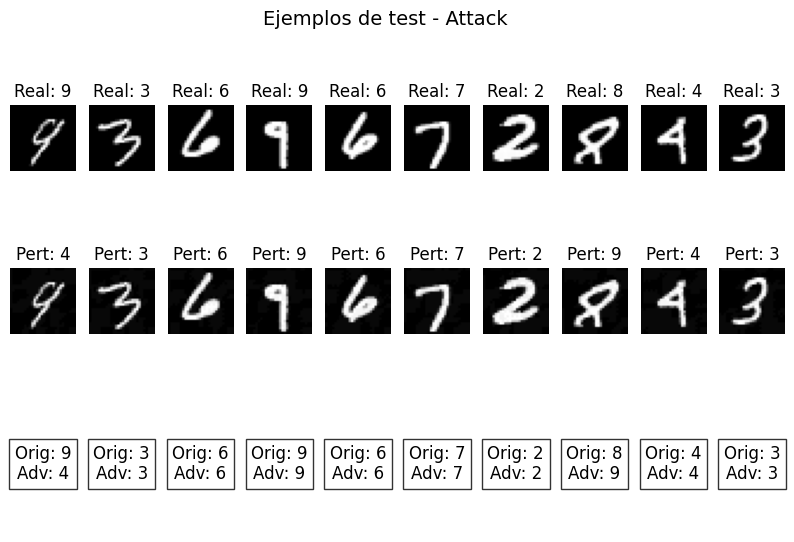

In [48]:
from torchattacks import FGSM  # Asegúrate de tener instalada la librería torchattacks

# Definir el ataque FGSM con el modelo y el valor de epsilon
attack = FGSM(ftb30p, eps=8/255)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)


In [49]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


,Clase 0,Clase 1,Clase 2,Clase 3,Clase 4,Clase 5,Clase 6,Clase 7,Clase 8,Clase 9
0,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.97
1,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
3,0.00,0.02,0.00,0.00,0.03,0.00,0.00,0.21,0.00,0.73
4,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
6,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.01,0.67,0.29
8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00


Probabilidades con ataque:


,Clase 0,Clase 1,Clase 2,Clase 3,Clase 4,Clase 5,Clase 6,Clase 7,Clase 8,Clase 9
0,0.00,0.00,0.00,0.00,0.53,0.00,0.00,0.00,0.01,0.45
1,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
3,0.00,0.03,0.00,0.00,0.04,0.00,0.00,0.41,0.00,0.51
4,0.00,0.00,0.00,0.00,0.01,0.00,0.99,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
6,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.03,0.11,0.84
8,0.00,0.00,0.00,0.00,0.98,0.00,0.00,0.00,0.00,0.02
9,0.00,0.00,0.01,0.98,0.00,0.00,0.00,0.00,0.00,0.00



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 249/250 (99.60%)
Aciertos después del ataque: 229/250 (91.60%)
Cambio de predicción en 20/250 imágenes (8.00%)


(np.float64(0.996), np.float64(0.916), np.float64(0.08))

## DeepFool attack 

In [42]:
import torch
import torch.nn as nn



class DeepFool(Attack):
    r"""
    'DeepFool: A Simple and Accurate Method to Fool Deep Neural Networks'
    [https://arxiv.org/abs/1511.04599]
    Distance Measure : L2
    Arguments:
        model (nn.Module): model to attack.
        steps (int): number of steps. (Default: 50)
        overshoot (float): parameter for enhancing the noise. (Default: 0.02)
    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.
    Examples::
        >>> attack = torchattacks.DeepFool(model, steps=50, overshoot=0.02)
        >>> adv_images = attack(images, labels)
    """

    def __init__(self, model, steps=50, overshoot=0.02):
        super().__init__("DeepFool", model)
        self.steps = steps
        self.overshoot = overshoot
        self.supported_mode = ["default"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """
        adv_images, target_labels = self.forward_return_target_labels(images, labels)
        return adv_images

    def forward_return_target_labels(self, images, labels):
        r"""
        Overridden.
        """
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        batch_size = len(images)
        correct = torch.tensor([True] * batch_size)
        target_labels = labels.clone().detach().to(self.device)
        curr_steps = 0

        adv_images = []
        for idx in range(batch_size):
            image = images[idx : idx + 1].clone().detach()
            adv_images.append(image)

        while (True in correct) and (curr_steps < self.steps):
            for idx in range(batch_size):
                if not correct[idx]:
                    continue
                early_stop, pre, adv_image = self._forward_indiv(
                    adv_images[idx], labels[idx]
                )
                adv_images[idx] = adv_image
                target_labels[idx] = pre
                if early_stop:
                    correct[idx] = False
            curr_steps += 1

        adv_images = torch.cat(adv_images).detach()
        return adv_images, target_labels

    def _forward_indiv(self, image, label):
        image.requires_grad = True
        fs = self.get_logits(image)[0]
        _, pre = torch.max(fs, dim=0)
        if pre != label:
            return (True, pre, image)

        ws = self._construct_jacobian(fs, image)
        image = image.detach()

        f_0 = fs[label]
        w_0 = ws[label]

        wrong_classes = [i for i in range(len(fs)) if i != label]
        f_k = fs[wrong_classes]
        w_k = ws[wrong_classes]

        f_prime = f_k - f_0
        w_prime = w_k - w_0
        value = torch.abs(f_prime) / torch.norm(nn.Flatten()(w_prime), p=2, dim=1)
        _, hat_L = torch.min(value, 0)

        delta = (
            torch.abs(f_prime[hat_L])
            * w_prime[hat_L]
            / (torch.norm(w_prime[hat_L], p=2) ** 2)
        )

        target_label = hat_L if hat_L < label else hat_L + 1

        adv_image = image + (1 + self.overshoot) * delta
        adv_image = torch.clamp(adv_image, min=0, max=1).detach()
        return (False, target_label, adv_image)

    # https://stackoverflow.com/questions/63096122/pytorch-is-it-possible-to-differentiate-a-matrix
    # torch.autograd.functional.jacobian is only for torch >= 1.5.1
    def _construct_jacobian(self, y, x):
        x_grads = []
        for idx, y_element in enumerate(y):
            if x.grad is not None:
                x.grad.zero_()
            y_element.backward(retain_graph=(False or idx + 1 < len(y)))
            x_grads.append(x.grad.clone().detach())
        return torch.stack(x_grads).reshape(*y.shape, *x.shape)

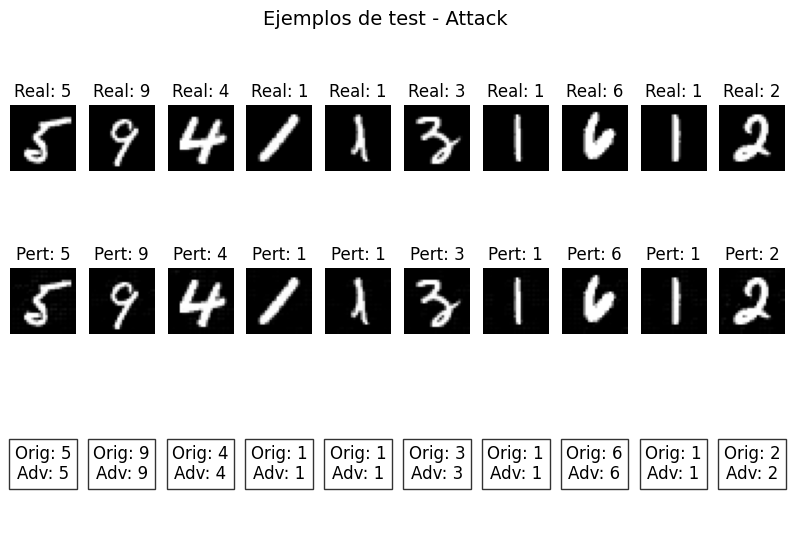

In [50]:
attack = DeepFool(ftb30p)
adv_images, batch_x, batch_y = Imagenes_attack(attack, ftb30p)

In [51]:
probabilities_attack2(adv_images, ftb30p, batch_x, batch_y)

Probabilidades originales:


,Clase 0,Clase 1,Clase 2,Clase 3,Clase 4,Clase 5,Clase 6,Clase 7,Clase 8,Clase 9
0,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
3,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
8,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Probabilidades con ataque:


,Clase 0,Clase 1,Clase 2,Clase 3,Clase 4,Clase 5,Clase 6,Clase 7,Clase 8,Clase 9
0,0.00,0.00,0.00,0.00,0.00,0.98,0.01,0.00,0.01,0.00
1,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.12,0.01,0.85
2,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.53,0.00,0.00,0.00,0.00,0.00,0.01,0.45,0.00
4,0.00,0.49,0.48,0.00,0.01,0.00,0.00,0.01,0.00,0.00
5,0.00,0.19,0.00,0.78,0.00,0.00,0.00,0.02,0.00,0.00
6,0.00,0.76,0.00,0.00,0.01,0.00,0.00,0.02,0.20,0.00
7,0.00,0.01,0.00,0.00,0.12,0.00,0.86,0.00,0.00,0.00
8,0.00,0.56,0.01,0.00,0.01,0.00,0.00,0.02,0.39,0.00
9,0.00,0.01,0.97,0.00,0.00,0.00,0.00,0.01,0.01,0.01



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 245/250 (98.00%)
Aciertos después del ataque: 237/250 (94.80%)
Cambio de predicción en 8/250 imágenes (3.20%)


(np.float64(0.98), np.float64(0.948), np.float64(0.032))